In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from domoku.board import GomokuBoard
from domoku.tools import GomokuTools as gt
from domoku.data import roll_out
from domoku.heuristics import Heuristics
from domoku.policies import HeuristicGomokuPolicy, ThreatSearch
import tensorflow as tf
from domoku.constants import *

In [12]:
from domoku.qfunction import heuristic_QF
from domoku.data import transform, create_sample, wrap_sample

In [2]:
tf.__version__

'2.8.0'

In [4]:
STYLE_MIXED=2

In [5]:
heuristics = Heuristics(kappa=3.0)

### Experimenting with smaller action spaces
Here we look at the board (states) that all evolve from an initial board. We're going to train on all board snapshots of a series of heuristically played games.

In [8]:
def new_initial_state(_heuristics):
    _board = GomokuBoard(_heuristics, n=15, disp_width=8)
    _policy = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5,
                                   threat_search=ThreatSearch(2,2))

    _board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10)
    return _board, _policy

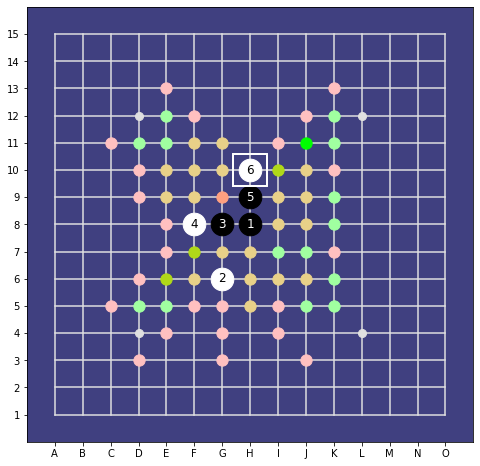

In [9]:
new_initial_state(heuristics)[0].display('current')

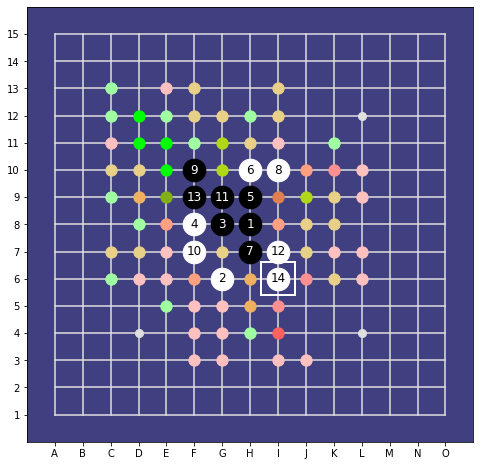

In [10]:
board, policy = new_initial_state(heuristics)
_ = roll_out(board, policy, 40)
board.display('current')

In [11]:
stones = board.stones.copy()

In [13]:
sample = create_sample(board.stones.copy(), board.N, 1-board.current_color)

In [14]:
o,d = np.rollaxis(sample, 2, 0)
2 * d + o

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
def create_samples_and_qvalues(_board, _heuristics):
    all_stones_t = [transform(_board.stones.copy(), _board.N, rot, ref)
                    for rot in range(4)
                    for ref in [False, True]]

    _samples = []
    qvalues = []
    for stones_t in all_stones_t:
        _sample = create_sample(stones_t, _board.N, 1 - _board.current_color)
        _board = GomokuBoard(heuristics=_heuristics, n=_board.N, stones=stones_t)
        _policy = HeuristicGomokuPolicy(style = STYLE_MIXED,
                                        bias=.5, topn=5,
                                       threat_search=ThreatSearch(2,2))

        qvalue, default_value = heuristic_QF(_board, _policy)
        qvalue = wrap_sample(qvalue, default_value)
        _samples.append(_sample)
        qvalues.append(qvalue)

    return np.array(_samples), np.reshape(qvalues, [8, _board.N + 2, _board.N + 2, 1])

In [16]:
samples, values = create_samples_and_qvalues(board, heuristics)

In [17]:
np.shape(samples),np.shape(values)

((8, 17, 17, 2), (8, 17, 17, 1))

In [18]:
b, w = np.rollaxis(samples[3], 2, 0)
b + 2*w

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Plausibility check

In [ ]:
index = np.argmax(values[3])
r, c = np.divmod(index,17)
pos=gt.m2b((r, c), 17)
print(r,c,pos, values[3][r][c])

In [ ]:
from domoku.data import create_samples_and_qvalues

In [ ]:
def data_from_game(_board, _policy, _heuristics):
    """
    Careful: This function rolls back the board
    """
    s,v = create_samples_and_qvalues(_board, _heuristics)
    while _board.cursor > 6:
        _board.undo()
        s1, v1 = create_samples_and_qvalues(_board, _heuristics)
        s = np.concatenate((s,s1))
        v = np.concatenate((v,v1))
    return s,v

In [ ]:
data = data_from_game(board, policy, heuristics)

In [ ]:
o,d = np.rollaxis(data[0][30], 2, 0)
2 * d + o

#### Yet another plausibility check

In [ ]:
sample_no = 30
index = np.argmax(data[1][sample_no])
r, c = np.divmod(index,17)
pos=gt.m2b((r, c), 17)
print(r,c,pos)
print("Value of the suggested pos:") 
print(data[1][sample_no][r][c])
print("Value to the right of the suggested pos:") 
print(data[1][sample_no][r][c+1])

## Save the results for later training

In [ ]:
np.save("samples.npy", data[0])
np.save("values.npy", data[1])

In [ ]:
samples = np.load("samples.npy")
values = np.load("values.npy")

In [ ]:
samples.shape, values.shape

In [ ]:
np.rollaxis(samples[0], 2, 0)

In [ ]:
np.rollaxis(values[0], 2, 0)

In [ ]:
np.rollaxis(samples[0], 2, 0)[0] + 2*np.rollaxis(samples[0], 2, 0)[1]